In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
#from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import Analyzer

In [ ]:
# 세번째 창은 차트나 지표를 필요로 하지 않는다. 단지 첫번째 창과
# 두번째 창이 동시에 매매 신호를 냈을 때 진입시점을 찾아내는 기법
#만 존재할 뿐이다. 주간 추세가 상승하면 추적 매수 스톱기법을 
# 사용해 가격 변동에 따라 주문 수준을 수정한다.
# 하락 추세에서는 추적 매도 스톱기법을 사용해 가격 변동에 따라
# 주문 수준을 수정해간다.

In [42]:
mk = Analyzer.MarketDB()
df = mk.get_daily_price('SK하이닉스', '2020-10-01')

end_date is initialized to '2022-02-02'


In [43]:
ema60 = df.close.ewm(span=60).mean()
ema130 = df.close.ewm(span=130).mean()
macd = ema60 - ema130
signal = macd.ewm(span=45).mean()
macdhist = macd - signal
df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

In [44]:
df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number','open','high','low','close']]

In [45]:
ndays_high = df.high.rolling(window=14, min_periods=1).max()
ndays_low = df.low.rolling(window=14, min_periods=1).min()

In [46]:
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k=fast_k, slow_d=slow_d).dropna()

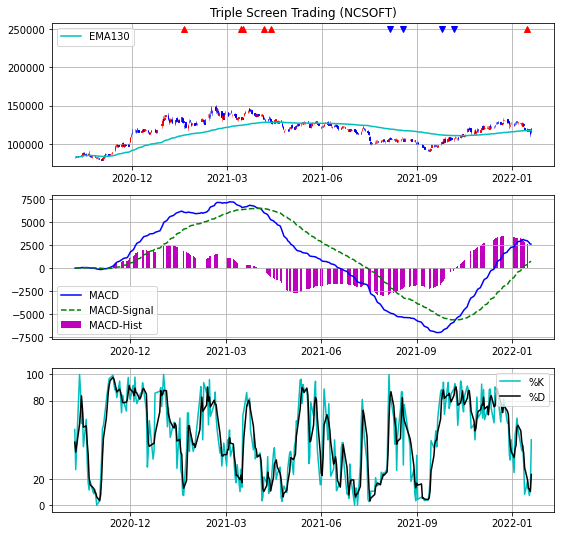

In [47]:
plt.figure(figsize=(9, 9))
p1 = plt.subplot(3, 1, 1)
plt.title('Triple Screen Trading (NCSOFT)')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup='red', colordown='blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color='c', label='EMA130')
for i in range(1, len(df.close)):
    if df.ema130.values[i-1] < df.ema130.values[i] and \
        df.slow_d.values[i-1] >= 20 and df.slow_d.values[i] < 20:
        plt.plot(df.number.values[i], 250000, 'r^') 
    elif df.ema130.values[i-1] > df.ema130.values[i] and \
        df.slow_d.values[i-1] <= 80 and df.slow_d.values[i] > 80:
        plt.plot(df.number.values[i], 250000, 'bv') 
plt.legend(loc='best')

p2 = plt.subplot(3, 1, 2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label='MACD-Hist')
plt.plot(df.number, df['macd'], color='b', label='MACD')
plt.plot(df.number, df['signal'], 'g--', label='MACD-Signal')
plt.legend(loc='best')

p3 = plt.subplot(3, 1, 3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color='c', label='%K')
plt.plot(df.number, df['slow_d'], color='k', label='%D')
plt.yticks([0, 20, 80, 100])
plt.legend(loc='best')
plt.show()